In [1]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 495, done.
remote: Counting objects: 100% (495/495), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 495 (delta 415), reused 451 (delta 395), pack-reused 0 (from 0)
Receiving objects: 100% (495/495), 2.36 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [4]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Import the dataset

In [16]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])
lst_ndvi = np.array(df_average.NDVI)

In [17]:
n_steps_in = 23
n_steps_out = 1

In [18]:
scaler = MinMaxScaler()
lst_ndvi = scaler.fit_transform(lst_ndvi.reshape(-1, 1))

#### Function to restructure the data for the model

In [19]:
def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

In [20]:
X, y = prepare_data(lst_ndvi, n_steps_in, n_steps_out)

## Keras tune
*   Definition of an integer hyperparameter: hp.Int(*hyperparameter*, min_value=#, max_value=#, step=#). This means that the *hyperparameter* will range from *min_value* to *max_value* inclusive with the minimum step for walking through the interval being *step*.

### Compile
Configures the model for training.

**Hyperparameters**
* **optimizer**: String (name of optimizer) or optimizer instance. Related to back propagation.
* **loss**: Loss function. fn(y_true, y_pred)
* **metrics**: List of metrics to be evaluated by the model during training and testing.

It looks like loss is for the fitting of the model and metrics is for the final evaluation.



In [21]:
def build_model_1layer(hp):
    model = Sequential()
    model.add(
        LSTM(units=hp.Int(f"units_0", min_value=10, max_value=100, step=10),
             activation='tanh',
             input_shape=(n_steps_in, 1)
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model

### To initialize the tuner

* **hypermodel**. The model-building function, which is build_model in our case.
* **objective**. The name of the objective to optimize.
* **max_trials**. The total number of trials to run during the search. Different trials have different hyperparameter values.
* **executions_per_trial**. The number of models that should be built and fit for each trial. It is like cross-validation.
* **overwrite**. Control whether to overwrite the previous results in the same directory or resume the previous search instead.
* **directory**. A path to a directory for storing the search results.
* **project_name**. The name of the sub-directory in the directory.

In [64]:
!rm -rf /content/lstm_tuning

In [23]:
tuner_1layer = kt.RandomSearch(
    build_model_1layer,
    objective='val_loss',
    max_trials=40,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='1layer'
)
tuner_1layer.search_space_summary()

Search space summary
Default search space size: 2
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(91, 23, 1)

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
tuner_1layer.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 40 Complete [00h 00m 30s]
val_loss: 0.021605160708228748

Best val_loss So Far: 0.01150559913367033
Total elapsed time: 00h 16m 16s


Show the sumary of the results

In [32]:
tuner_1layer.results_summary()


Results summary
Results in lstm_tuning/1layer
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 25 summary
Hyperparameters:
units_0: 70
lr: 0.006184222375640603
Score: 0.01150559913367033

Trial 16 summary
Hyperparameters:
units_0: 60
lr: 0.006423597973604284
Score: 0.013072832487523556

Trial 03 summary
Hyperparameters:
units_0: 40
lr: 0.008847108230417601
Score: 0.014132944246133169

Trial 17 summary
Hyperparameters:
units_0: 50
lr: 0.005594661103196281
Score: 0.015145217689375082

Trial 14 summary
Hyperparameters:
units_0: 60
lr: 0.003956370567137552
Score: 0.015200677948693434

Trial 01 summary
Hyperparameters:
units_0: 30
lr: 0.004817411854480006
Score: 0.01640612694124381

Trial 24 summary
Hyperparameters:
units_0: 10
lr: 0.006156805850411143
Score: 0.019989207697411377

Trial 13 summary
Hyperparameters:
units_0: 70
lr: 0.002242865877928494
Score: 0.0207215982178847

Trial 39 summary
Hyperparameters:
units_0: 90
lr: 0.0021418200870065777
Score: 0.021605160

Best result so far:
* units: 40
* lr: 0.00976844384018483
* Score: 0.01515659037977457

The other best result is
num_layers: 1
units_0: 60
lr: 0.006429326855520711
units_1: 20
units_2: 100
Score: 0.018751021474599838

In [30]:
tuner_1layer.get_best_hyperparameters(1)[0].values

{'units_0': 70, 'lr': 0.006184222375640603}

In [33]:
best_model_1layer = tuner_1layer.get_best_models(num_models=1)[0]
best_model_1layer.fit(X, y, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0483 - root_mean_squared_error: 0.2131 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0174 - root_mean_squared_error: 0.1316 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.1218 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0116 - root_mean_squa

In [35]:
print(root_mean_squared_error(y.flatten(), best_model_1layer.predict(X).flatten()))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.10003217577975555


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


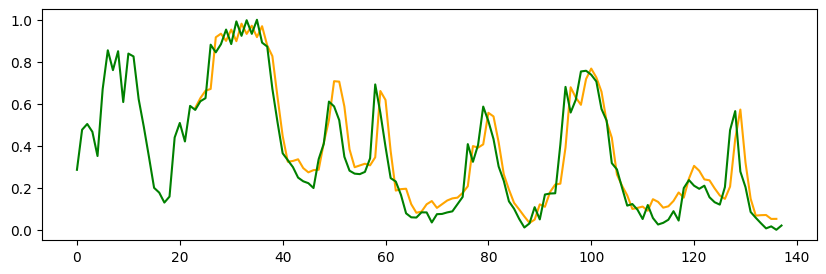

In [36]:
Total_pred = best_model_1layer.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
#plt.plot(np.concatenate((lst_ndvi,predictions)), label = 'Predicted', c = 'green')
plt.show()

## 2 Layers

In [ ]:
def build_model_2layer(hp):
    model = Sequential()
    cells = hp.Int(f"units_0", min_value=10, max_value=100, step=10)
    model.add(
        LSTM(units=cells,
             activation='tanh',
             input_shape=(n_steps_in, 1),
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=cells,
             activation='tanh'
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model


tuner_2layer = kt.RandomSearch(
    build_model_2layer,
    objective='val_loss',
    max_trials=40,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='2layer'
)
tuner_2layer.search_space_summary()

tuner_2layer.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])


Trial 16 Complete [00h 01m 06s]
val_loss: 0.19835267961025238

Best val_loss So Far: 0.031407528867324196
Total elapsed time: 00h 16m 38s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
100               |80                |units_0
0.00069206        |0.0034019         |lr



In [45]:
tuner_2layer.search_space_summary()


Search space summary
Default search space size: 2
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [62]:
tuner_2layer.get_best_hyperparameters(1)[0].values
best_model_2layer = tuner_2layer.get_best_models(num_models=1)[0]
best_model_2layer.fit(X, y, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])
print(root_mean_squared_error(y.flatten(), best_model_2layer.predict(X).flatten()))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - loss: 0.0743 - root_mean_squared_error: 0.2722 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.0619 - val_root_mean_squared_error: 0.2488
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0565 - root_mean_squared_error: 0.2375 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2462
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387 - val_loss: 0.0578 - val_root_mean_squared_error: 0.2403
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0523 - root_mean_squared_error: 0.2285 - val_loss: 0.0538 - val_root_mean_squared_error: 0.2320
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0489 - root_mean_squa

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


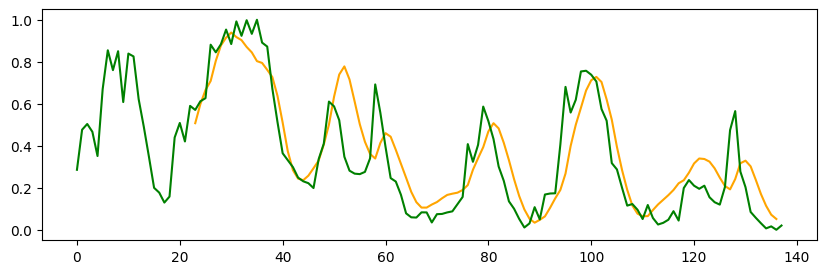

In [63]:
Total_pred = best_model_2layer.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

In [51]:
best_model_2layer.summary()
tuner_2layer.get_best_hyperparameters(1)[0].values

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 23, 80)              │          26,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 80)                  │          51,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,525 (912.21 KB)

 Trainable params: 77,841 (304.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 155,684 (608.14 KB)

{'units_0': 80, 'lr': 0.0014951135160520678}

## 3 Layers

In [ ]:
def build_model_3layer(hp):
    model = Sequential()
    model.add(
        LSTM(units=hp.Int(f"units_0", min_value=10, max_value=100, step=10),
             activation='tanh',
             input_shape=(n_steps_in, 1),
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=hp.Int(f"units_1", min_value=10, max_value=100, step=10),
             activation='tanh',
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=hp.Int(f"units_2", min_value=10, max_value=100, step=10),
             activation='tanh'
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model


tuner_3layer = kt.RandomSearch(
    build_model_3layer,
    objective='val_loss',
    max_trials=40,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='3layer'
)
tuner_3layer.search_space_summary()

tuner_3layer.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])


In [ ]:
tuner_3layer.get_best_hyperparameters(1)[0].values
best_model_3layer = tuner_3layer.get_best_models(num_models=1)[0]
best_model_3layer.fit(X, y, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])
print(root_mean_squared_error(y.flatten(), best_model_3layer.predict(X).flatten()))

In [ ]:
Total_pred = best_model_3layer.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

## Export data

In [40]:
!zip -r folder_name.zip /content/lstm_tuning


  adding: content/lstm_tuning/ (stored 0%)
  adding: content/lstm_tuning/1layer/ (stored 0%)
  adding: content/lstm_tuning/1layer/trial_25/ (stored 0%)
  adding: content/lstm_tuning/1layer/trial_25/build_config.json (stored 0%)
  adding: content/lstm_tuning/1layer/trial_25/trial.json (deflated 60%)
  adding: content/lstm_tuning/1layer/trial_25/checkpoint.weights.h5 (deflated 12%)
  adding: content/lstm_tuning/1layer/trial_31/ (stored 0%)
  adding: content/lstm_tuning/1layer/trial_31/build_config.json (stored 0%)
  adding: content/lstm_tuning/1layer/trial_31/trial.json (deflated 60%)
  adding: content/lstm_tuning/1layer/trial_31/checkpoint.weights.h5 (deflated 13%)
  adding: content/lstm_tuning/1layer/trial_22/ (stored 0%)
  adding: content/lstm_tuning/1layer/trial_22/build_config.json (stored 0%)
  adding: content/lstm_tuning/1layer/trial_22/trial.json (deflated 60%)
  adding: content/lstm_tuning/1layer/trial_22/checkpoint.weights.h5 (deflated 20%)
  adding: content/lstm_tuning/1layer/

In [ ]:
from google.colab import files
files.download('folder_name.zip')

In [41]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model.load("/content/drive/MyDrive/Master")